[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/devdio/2025-ksci-agent/blob/main/05-prebuilt-create-supervisor.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/devdio/2025-ksci-agent/blob/main/05-prebuilt-create-supervisor.ipynb)

# `create_supervisor`함수를 사용한 멀티 에이전트

이전의 튜토리얼은 Supervisor 에이전트를 `create_react_agent`함수를 사용해서 구현하였다. LangGraph에서는 supervisor 패턴의 멀티 에이전트를 간편하게 구현할 수 있게 `create_supervisor` 함수를 제공합니다. 또한 Swam 패턴의 멀티에이전트 시스템 구현을 위한 [`langgraph-swarm` 라이브러리](https://github.com/langchain-ai/langgraph-swarm-py)도 제공됩니다. 

이번 튜토리얼에서는 이 함수를 사용하여 이전의 튜토리얼을 수정합니다.

## 1. 환경설정

### 팩키지 설치

In [6]:
%pip install -qU python-dotenv langgraph langsmith langchain-openai langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:10])
print(os.environ.get("TAVILY_API_KEY")[:10])

sk-proj-8x
tvly-dev-G


In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "KSCI-Agent"

print(os.environ.get("LANGSMITH_API_KEY")[:10])

lsv2_pt_a5


### 메세지 프린트 함수
그래프의 실행 결과인 메세지를 확인하기 편리하도록 함수를 준비합니다.

In [4]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 2. 에이전트 생성

먼저, 두 개의 전문 워커 에이전트인 리서치 에이전트와 수학 에이전트를 만들어보겠습니다:

- 리서치 에이전트는 Tavily API를 사용한 웹 검색 도구에 접근할 수 있습니다.
- 수학 에이전트는 더하기, 곱하기, 나누기와 같은 간단한 수학 도구에 접근할 수 있습니다.

### 리서치 에이전트

In [5]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [6]:
web_search_results = web_search.invoke("2025년 미국의 대통령은 누구인가?")
web_search_results["results"][0]["content"]

'[LIVE][KBS뉴스특보] 미국 47대 대통령 도널드 트럼프 취임식/2025년 1월 21일(화)/KBS\n\nKBS News\n1866 likes\n306947 views\n21 Jan 2025\n미국의 47대 대통령으로 도널드 트럼프 당선인이 취임합니다. \n\n8년 전 취임식에서 "미국을 다시 위대하게!"를 외쳤던 트럼프 당선인이 4년 만에 다시 백악관으로 입성합니다.\n\n전세계의 이목이 쏠리고 있는 취임식 현장, KBS 뉴스 특보로 전해드립니다. \n\n#트럼프 #maga #취임식 #미국\n\nCopyright ⓒ KBS. All rights reserved. 무단 전재, 재배포 및 이용(AI 학습 포함) 금지 \n\n\n▣ KBS뉴스 유튜브 구독하기 : https://goo.gl/qCWZjZ\n▣ KBS뉴스 유튜브 커뮤니티 : https://goo.gl/6yko39\n▣ KBS 뉴스  \n◇ PC : http://news.kbs.co.kr    \n◇ 모바일 : http://mn.kbs.co.kr \n▣ 인스타그램 : https://www.instagram.com/kbsnews    \n▣ 페이스북 : https://www.facebook.com/kbsnews  \n▣ 트위터 : https://twitter.com/kbsnews\n▣ 틱톡 :  https://tiktok.com/@kbsnewsofficial\n93 comments'

이전의 튜토리얼과 다르게 별도의 노드(Node)를 구성하지 않고, Agent 생성만 진행한다.

In [7]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[web_search],
    prompt=(
        "당신은 리서치 에이전트입니다.\n\n"
        "지침:\n"
        "- 오직 리서치(조사) 관련 작업만 도와야 하며, 수학 계산은 절대 하지 마세요\n"
        "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
        "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."

    ),
    name="research_agent",
)

### 수학 에이전트

노드(Node)를 구성하지 않고 Agent 생성만 진행한다.

In [8]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[add, multiply, divide],
    prompt=(
        "당신은 수학 에이전트입니다.\n\n"
        "지침:\n"
        "- 오직 수학 관련 작업만 도와야 합니다\n"
        "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
        "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
    ),
    name="math_agent",
)

### 🤖 슈퍼바이저 에이전트 
`langgraph-supervisor`라이브러리를 설치한다. 자세한 내용은 [LangGraph Multi-Agent Supervisor](https://github.com/langchain-ai/langgraph-supervisor-py) 페이지를 참고하세요.

In [9]:
%pip install -qU langgraph-supervisor

Note: you may need to restart the kernel to use updated packages.


In [10]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4o-mini"),
    agents=[research_agent, math_agent],    # 에이전트를 추가한다.
    prompt=(
        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 리서치 에이전트: 리서치(조사) 관련 작업을 이 에이전트에게 할당하세요\n"
        "- 수학 에이전트: 수학 관련 작업을 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
    ),
    # supervisor가 작업을 다음 에이전트에게 넘기기 전에, 이전 에이전트가 생성한 메시지를 명시적으로 포함
    add_handoff_back_messages=True,
    # 사용자 입력, supervisor 결정, 각 agent의 응답 등 모든 중간 단계를 포함한 전체 기록을 제공합니다.
    output_mode="full_history",
).compile()

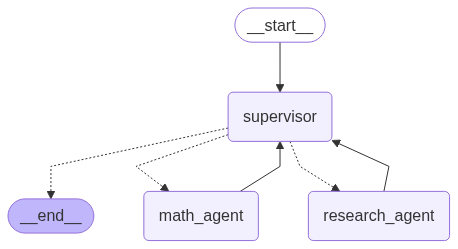

In [11]:
from IPython.display import Image, display

try:
    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 3. 실행

In [12]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "2024년 미국 전체 GDP와 뉴욕주의 GDP를 찾아줘.그리고 뉴욕주의 GDP가 미국 GDP의 몇 퍼센트인지 `math_agent`로 계산해줘.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

2024년 미국 GDP는 약 29.18 조 달러이고, 뉴욕주 GDP는 약 2.297 조 달러입니다. 뉴욕주의 GDP는 미국 GDP의 약 7.87%에 해당합니다.


